In [1]:
% load_ext autoreload
% autoreload 2

import numpy as np
import pandas as pd
from utils import *
import torch
from torch import nn
from torch.nn import functional as F
from sklearn.model_selection import train_test_split
import torch.utils.data as Data
from easydict import EasyDict as ed
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import seaborn as sns

sns.reset_defaults()
clr = sns.color_palette("deep")

np.random.seed(0)
torch.manual_seed(0)
import random

random.seed(0)

import matplotlib

matplotlib.rc('text', usetex=True)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['figure.autolayout'] = True
plt.rcParams['legend.frameon'] = False

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

extend_features = False
normalize = True
validation = True
physics_informed = False

Using cpu device


In [2]:
data = pd.read_excel('../data/316_creep_fatigue_life_prediction.xlsx', engine='openpyxl').dropna()

name_mapping = {
    'wt.C': 'wt.C',
    'wt.Si': 'wt.Si',
    'wt.Mn': 'wt.Mn',
    'wt.P': 'wt.P',
    'wt.S': 'wt.S',
    'wt.Ni': 'wt.Ni',
    'wt.Cr': 'wt.Cr',
    'wt.Mo': 'wt.Mo',
    'wt.N': 'wt.N',
    'temperature(celsius)': 'temperature',
    'strain_amplitude(%)': 'strain amplitude',
    'hold_time(h)': 'hold time',
    'strain_rate(s-1)': 'strain rate',
    'fatigue_life': 'fatigue life'
}

data = replace_column_name(data, name_mapping)
data = data.drop(np.where(data['temperature'] < 550)[0]).reset_index(drop=True)
data = data.drop(np.where(data['temperature'] > 650)[0]).reset_index(drop=True)
data = data.drop(np.where(data['fatigue life'] > 100000)[0]).reset_index(drop=True)

df_yt = pd.read_csv('../data/yield_strength_temperature.csv')
yield_strength = np.interp(data['temperature'], df_yt['X'], df_yt['Y'])

SFE = 39 + 1.59 * data['wt.Ni'] - 1.34 * data['wt.Mn'] + 0.06 * data['wt.Mn'] ** 2 - 1.75 * data['wt.Cr'] + 0.01 * data[
    'wt.Cr'] ** 2 + 15.21 * data['wt.Mo'] - 5.59 * data['wt.Si'] - 60.69 * (
                  data['wt.C'] + 1.2 * data['wt.N']) ** 0.5 + 26.27 * (data['wt.C'] + 1.2 * data['wt.N']) * (
                  data['wt.Cr'] + data['wt.Mn'] + data['wt.Mo']) ** 0.5 + 0.61 * (
                  data['wt.Ni'] * (data['wt.Cr'] + data['wt.Mn'])) ** 0.5
data['SFE'] = SFE
data['yield strength'] = yield_strength

if extend_features:
    feature_names = ['wt.C', 'wt.Si', 'wt.Mn',
                     'wt.P', 'wt.S', 'wt.Ni', 'wt.Cr', 'wt.Mo', 'wt.N', 'temperature',
                     'strain amplitude', 'hold time', 'strain rate', 'SFE', 'yield strength']
else:
    feature_names = ['wt.C', 'wt.Si', 'wt.Mn',
                     'wt.P', 'wt.S', 'wt.Ni', 'wt.Cr', 'wt.Mo', 'wt.N', 'temperature',
                     'strain amplitude', 'hold time', 'strain rate']

label_name = ['fatigue life']

if normalize:
    for feature in feature_names:
        col = np.array(data[feature])
        col = (col - np.min(col)) / (np.max(col) - np.min(col))
        data.loc[:, feature] = col

feature_data = data[feature_names]
label_data = np.log10(data[label_name])

X = torch.tensor(feature_data.values, dtype=torch.float32).to(device)
y = torch.tensor(label_data.values, dtype=torch.float32).to(device)
dataset = Data.TensorDataset(X, y)

if validation:
    train_val_test = np.array([0.6, 0.2, 0.2])
    train_size = np.floor(len(label_data) * train_val_test[0]).astype(int)
    val_size = np.floor(len(label_data) * train_val_test[1]).astype(int)
    test_size = len(label_data) - train_size - val_size
    train_dataset, val_dataset, test_dataset = Data.random_split(dataset, [train_size, val_size, test_size])

    print(len(train_dataset), len(val_dataset), len(test_dataset))
else:
    train_test = np.array([0.8, 0.2])
    train_size = np.floor(len(label_data) * train_test[0]).astype(int)
    test_size = len(label_data) - train_size
    train_dataset, test_dataset = Data.random_split(dataset, [train_size, test_size])
    print(len(train_dataset), len(test_dataset))

87 29 30


In [3]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_normal_(m.weight)


class NN(nn.Module):
    def __init__(self, layers=[128, 64, 32]):
        super(NN, self).__init__()
        num_inputs = len(feature_names)
        num_hiddens1 = layers[0]
        num_hiddens2 = layers[1]
        num_hiddens3 = layers[2]
        num_outputs = len(label_name)
        self.net = nn.Sequential()
        self.net.add_module('input', nn.Linear(num_inputs, layers[0]))
        self.net.add_module('ReLU', nn.ReLU())
        for idx in range(len(layers) - 1):
            self.net.add_module(str(idx), nn.Linear(layers[idx], layers[idx + 1]))
            self.net.add_module('ReLU' + str(idx), nn.ReLU())
        self.net.add_module('output', nn.Linear(layers[-1], num_outputs))

        # self.net.apply(init_weights)

    def forward(self, x):
        x = self.net(x)
        return x


def train(model, params, train_loader, optimizer, loss_fn):
    model.train()
    avg_loss = 0
    for idx, (data, yhat) in enumerate(train_loader):
        optimizer.zero_grad()
        y = model(data)
        loss = loss_fn(yhat, y)
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() * len(y)

    avg_loss /= len(train_loader.dataset)
    return avg_loss


def test(model, params, test_loader, loss_fn):
    model.eval()
    pred = []
    truth = []
    with torch.no_grad():
        # print(test_dataset)
        avg_loss = 0
        for idx, (data, yhat) in enumerate(test_loader):
            y = model(data)
            loss = loss_fn(yhat, y)
            avg_loss += loss.item() * len(y)
            pred += list(y.detach().numpy())
            truth += list(yhat.detach().numpy())
        avg_loss /= len(test_loader.dataset)
    return np.array(pred), np.array(truth), avg_loss

In [4]:

params = ed({
    'lr': 0.01,
    'weight_decay': 0,
    'epoch': 10000,
    'least_epoch': 5000,
    'patience': 1000,
    'batch_size': 256,
    'layers': [16, 32, 64, 64, 32, 16]
})

train_loader = Data.DataLoader(train_dataset, batch_size=params.batch_size)
if validation:
    val_loader = Data.DataLoader(val_dataset, batch_size=len(val_dataset))
test_loader = Data.DataLoader(test_dataset, batch_size=len(test_dataset))

model = NN(params.layers).to(device)

optimizer = torch.optim.Adam(model.parameters(),
                             lr=params.lr,
                             weight_decay=params.weight_decay)


class PI_MSELoss(nn.Module):
    def __init__(self, eps=1e-8):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps

    def forward(self, yhat, y):
        loss = self.mse(yhat, y) + self.eps + torch.sum(F.relu(-y)) / len(y) + torch.sum(F.relu(y - 5)) / len(y)
        return loss


if physics_informed:
    loss_fn = PI_MSELoss()
else:
    loss_fn = nn.MSELoss()

train_ls = []
val_ls = []
stop_epoch = params.epoch

early_stopping = EarlyStopping(patience=params.patience, verbose=False)

for epoch in range(params.epoch):
    train_loss = train(model, params, train_loader, optimizer, loss_fn)
    train_ls.append(train_loss)
    if validation:
        _, _, val_loss = test(model, params, val_loader, loss_fn)
        val_ls.append(val_loss)

    if (epoch + 1) % 200 == 0 or epoch == 0:
        if validation:
            print(f'Epoch: {epoch + 1}/{params.epoch}, Train loss: {train_loss:.4f}, Val loss: {val_loss:.4f}')
        else:
            print(f'Epoch: {epoch + 1}/{params.epoch}, Train loss: {train_loss:.4f}')

    if validation:
        early_stopping(val_loss, model)

        if epoch > params.least_epoch and early_stopping.early_stop:
            print(
                f'Early stopping at epoch {epoch + 1}, Checkpoint at epoch {val_ls.index(min(val_ls)) + 1}, Train loss: {train_loss:.4f}, Val loss: {val_loss:.4f}')
            stop_epoch = epoch + 1
            break

Epoch: 1/10000, Train loss: 11.2616, Val loss: 10.4675
Epoch: 200/10000, Train loss: 0.0755, Val loss: 0.1082
Epoch: 400/10000, Train loss: 0.0462, Val loss: 0.0902
Epoch: 600/10000, Train loss: 0.0360, Val loss: 0.0801
Epoch: 800/10000, Train loss: 0.0363, Val loss: 0.0788
Epoch: 1000/10000, Train loss: 0.0279, Val loss: 0.0908
Epoch: 1200/10000, Train loss: 0.0239, Val loss: 0.0849
Epoch: 1400/10000, Train loss: 0.0191, Val loss: 0.0725
Epoch: 1600/10000, Train loss: 0.0219, Val loss: 0.0717
Epoch: 1800/10000, Train loss: 0.0134, Val loss: 0.0690
Epoch: 2000/10000, Train loss: 0.0113, Val loss: 0.0694
Epoch: 2200/10000, Train loss: 0.0079, Val loss: 0.0725
Epoch: 2400/10000, Train loss: 0.0075, Val loss: 0.0709
Epoch: 2600/10000, Train loss: 0.0074, Val loss: 0.0699
Epoch: 2800/10000, Train loss: 0.0120, Val loss: 0.0711
Epoch: 3000/10000, Train loss: 0.0087, Val loss: 0.0677
Epoch: 3200/10000, Train loss: 0.0084, Val loss: 0.0679
Epoch: 3400/10000, Train loss: 0.0072, Val loss: 0.06

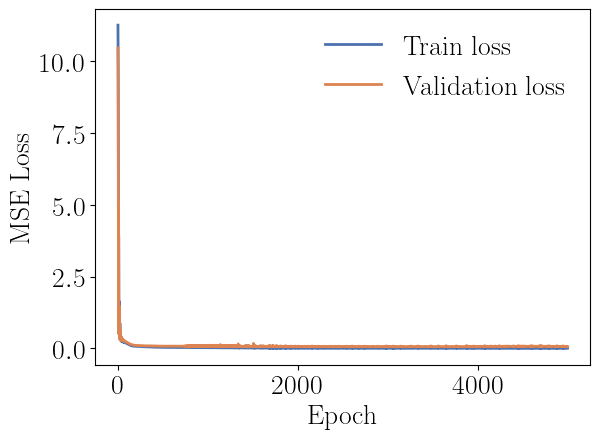

In [5]:
plt.figure()
plt.rcParams['font.size'] = 20
ax = plt.subplot(111)
ax.plot(np.arange(stop_epoch), train_ls, label='Train loss', linewidth=2, color=clr[0])
if validation:
    ax.plot(np.arange(stop_epoch), val_ls, label='Validation loss', linewidth=2, color=clr[1])
# minposs = val_ls.index(min(val_ls))+1 
# ax.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')
ax.legend()
ax.set_ylabel('MSE Loss')
ax.set_xlabel('Epoch')
plt.savefig('../output/loss_epoch.svg')
plt.show()

MSE Loss: 0.0095, R2: 0.9743
MSE Loss: 0.0730, R2: 0.8084
MSE Loss: 0.0519, R2: 0.7178


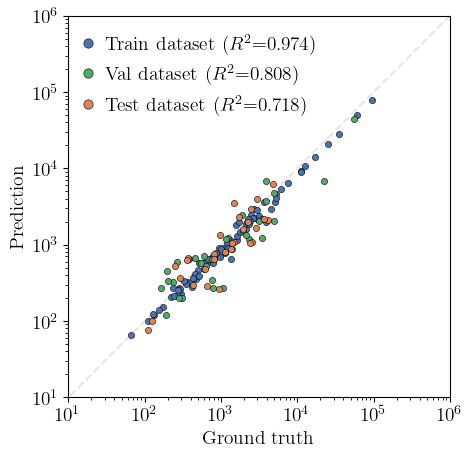

In [21]:
plt.figure()
plt.rcParams['font.size'] = 14
ax = plt.subplot(111)

prediction, ground_truth, loss = test(model, params, train_loader, loss_fn)
r2 = r2_score(ground_truth, prediction)
print(f'MSE Loss: {loss:.4f}, R2: {r2:.4f}')
plot_truth_pred(ax, 10 ** ground_truth, 10 ** prediction, s=20, color=clr[0], label=f'Train dataset ($R^2$={r2:.3f})',
                linewidth=0.4, edgecolors='k')

if validation:
    prediction, ground_truth, loss = test(model, params, val_loader, loss_fn)
    r2 = r2_score(ground_truth, prediction)
    print(f'MSE Loss: {loss:.4f}, R2: {r2:.4f}')
    plot_truth_pred(ax, 10 ** ground_truth, 10 ** prediction, s=20, color=clr[2], label=f'Val dataset ($R^2$={r2:.3f})',
                    linewidth=0.4, edgecolors='k')

prediction, ground_truth, loss = test(model, params, test_loader, loss_fn)
r2 = r2_score(ground_truth, prediction)
print(f'MSE Loss: {loss:.4f}, R2: {r2:.4f}')
plot_truth_pred(ax, 10 ** ground_truth, 10 ** prediction, s=20, color=clr[1], label=f'Test dataset ($R^2$={r2:.3f})',
                linewidth=0.4, edgecolors='k')

ax.set_xscale('log')
ax.set_yscale('log')

ax.plot(np.linspace(0, 10 ** 8, 100), np.linspace(0, 10 ** 8, 100), '--', c='grey', alpha=.2, )
ax.set_aspect('equal', 'box')
locmin = matplotlib.ticker.LogLocator(base=10.0, subs=[0.1 * x for x in range(10)], numticks=20)

ax.set(xlim=[10, 10 ** 6], ylim=[10, 10 ** 6])
ax.xaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
# data_range = [
#     np.floor(np.min([np.min(ground_truth), np.min(prediction)])),
#     np.ceil(np.max([np.max(ground_truth), np.max(prediction)]))
# ]
plt.legend(loc='upper left', markerscale=1.5, handlelength=0.2, handleheight=0.9)

plt.savefig('../output/truth_pred.svg')
plt.show()

/home/xlluo/hdd/ML-fracture/venv/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


MSE Loss: 0.0082, R2: 0.9781
MSE Loss: 0.0450, R2: 0.7551


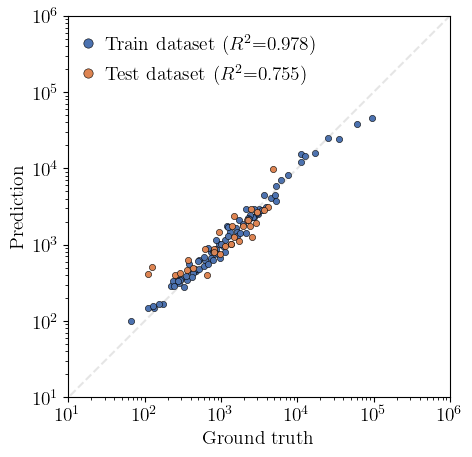

In [22]:
from random import Random
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_jobs=-1)
train_x_rf = feature_data.loc[train_dataset.indices, :]
train_y_rf = label_data.loc[train_dataset.indices, :]

test_x_rf = feature_data.loc[test_dataset.indices, :]
test_y_rf = label_data.loc[test_dataset.indices, :]

rf.fit(train_x_rf, train_y_rf)

plt.figure()
plt.rcParams['font.size'] = 14
ax = plt.subplot(111)

pred_y = rf.predict(train_x_rf)
r2 = r2_score(train_y_rf, pred_y)
loss = np.mean((train_y_rf.values[:, 0] - pred_y) ** 2)
print(f'MSE Loss: {loss:.4f}, R2: {r2:.4f}')
plot_truth_pred(ax, 10 ** train_y_rf, 10 ** pred_y, s=20, color=clr[0], label=f'Train dataset ($R^2$={r2:.3f})',
                linewidth=0.4, edgecolors='k')

pred_y = rf.predict(test_x_rf)
r2 = r2_score(test_y_rf, pred_y)
loss = np.mean((test_y_rf.values[:, 0] - pred_y) ** 2)
print(f'MSE Loss: {loss:.4f}, R2: {r2:.4f}')
plot_truth_pred(ax, 10 ** test_y_rf, 10 ** pred_y, s=20, color=clr[1], label=f'Test dataset ($R^2$={r2:.3f})',
                linewidth=0.4, edgecolors='k')

ax.set_xscale('log')
ax.set_yscale('log')

ax.plot(np.linspace(0, 10 ** 8, 100), np.linspace(0, 10 ** 8, 100), '--', c='grey', alpha=.2, )
ax.set_aspect('equal', 'box')
locmin = matplotlib.ticker.LogLocator(base=10.0, subs=[0.1 * x for x in range(10)], numticks=20)

ax.set(xlim=[10, 10 ** 6], ylim=[10, 10 ** 6])
ax.xaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
# data_range = [
#     np.floor(np.min([np.min(ground_truth), np.min(prediction)])),
#     np.ceil(np.max([np.max(ground_truth), np.max(prediction)]))
# ]
plt.legend(loc='upper left', markerscale=1.5, handlelength=0.2, handleheight=0.9)

plt.savefig('../output/rf_truth_pred.svg')
plt.show()

/home/xlluo/hdd/ML-fracture/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


MSE Loss: 0.0809, R2: 0.7825
MSE Loss: 0.0676, R2: 0.6323


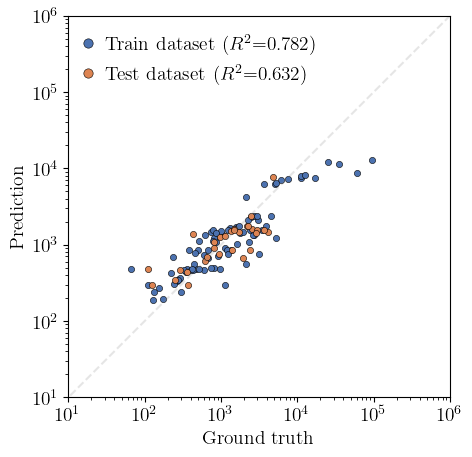

In [23]:
from sklearn import svm

sv = svm.SVR()
sv.fit(train_x_rf, train_y_rf)

plt.figure()
plt.rcParams['font.size'] = 14
ax = plt.subplot(111)

pred_y = sv.predict(train_x_rf)
r2 = r2_score(train_y_rf, pred_y)
loss = np.mean((train_y_rf.values[:, 0] - pred_y) ** 2)
print(f'MSE Loss: {loss:.4f}, R2: {r2:.4f}')
plot_truth_pred(ax, 10 ** train_y_rf, 10 ** pred_y, s=20, color=clr[0], label=f'Train dataset ($R^2$={r2:.3f})',
                linewidth=0.4, edgecolors='k')

pred_y = sv.predict(test_x_rf)
r2 = r2_score(test_y_rf, pred_y)
loss = np.mean((test_y_rf.values[:, 0] - pred_y) ** 2)
print(f'MSE Loss: {loss:.4f}, R2: {r2:.4f}')
plot_truth_pred(ax, 10 ** test_y_rf, 10 ** pred_y, s=20, color=clr[1], label=f'Test dataset ($R^2$={r2:.3f})',
                linewidth=0.4, edgecolors='k')

ax.set_xscale('log')
ax.set_yscale('log')

ax.plot(np.linspace(0, 10 ** 8, 100), np.linspace(0, 10 ** 8, 100), '--', c='grey', alpha=.2, )
ax.set_aspect('equal', 'box')
locmin = matplotlib.ticker.LogLocator(base=10.0, subs=[0.1 * x for x in range(10)], numticks=20)

ax.set(xlim=[10, 10 ** 6], ylim=[10, 10 ** 6])
ax.xaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
# data_range = [
#     np.floor(np.min([np.min(ground_truth), np.min(prediction)])),
#     np.ceil(np.max([np.max(ground_truth), np.max(prediction)]))
# ]
plt.legend(loc='upper left', markerscale=1.5, handlelength=0.2, handleheight=0.9)

plt.savefig('../output/sv_truth_pred.svg')
plt.show()